## Creating Shadow Volume

빛이 나는 부분은 0이 담기고, 그림자로 가려진 부분은 0이외의 수가 담기는 Stencil Buffer를 세팅하기 위해서,   
우리는 <b>shadow volume</b>이라고 불리는 것을 사용한다.   

    A shadow volume is a 3D polygon “wrapped” around the volume of space that’s in shadow from a light.   
    
shadow volume은 <b>그림자에 의해서 가려진 3차원 공간을 감싸는 3D 폴리곤</b>이다.

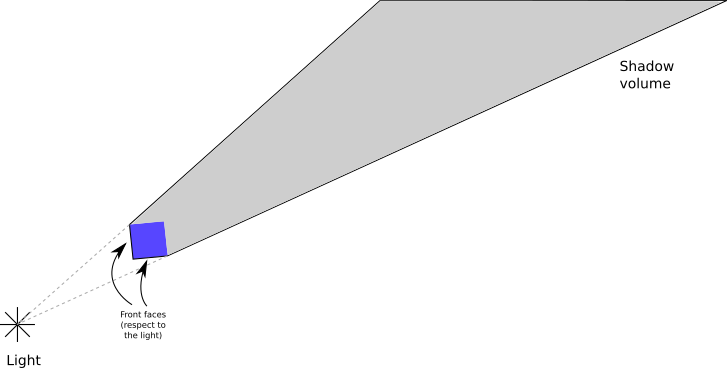


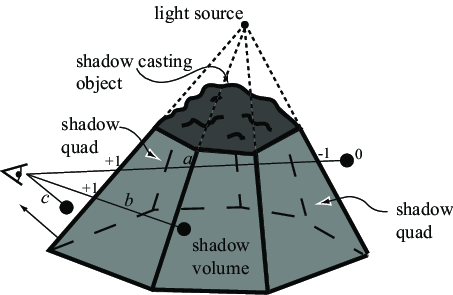

### How to Make a Shadow Volume

1. 어떤 모서리가 물체의 실루엣을 구성하는지를 먼저 찾아낸다. 이들은 front-facing과 back-facing triangle사이의 모서리이다.  
2. 그런다음 빛으로부터 extrude한다(to force, press, or push out). 무한하게 또는 매우 먼 지점으로.
3. 위에서 shadow volume의 side를 얻을 수가 있다.   
4. shadow volume의 앞면은 front-facing triangle을 이용하고,
5. shadow volume의 뒷면은 멀리 extrude된 edge들을 edge로 사용하는 폴리곤을 만들면 된다.

다음으로 이 shadow volume을 이용해 스텐실 버퍼를 계산하는 방법을 알아볼 것이다.

## Counting Shadow Volume-Ray Intersections

빛 광선이 카메라에서부터 나아가서 물체의 표면에 닿는 모습을 상상해보라.   
가는 도중에 여러 shadow volume에 들어갔다가 나올 것이다.   

우리는 이것을 0에서 부터 시작하는 카운터로 셀수가 있다.  
Ray가 shadow volume에서 들어갈 때 마다 카운터를 1 올리고(increment)하고,
shadow volume에서 나갈 때 마다 1을 내려(decrement)한다. 

카운터를 올리고 내리며, 뻗어나가 다가. 표면에 도달하는 순간의 카운터를 본다.   

카운터가 0이면 shadow volume에 들어간 만큼, 나갔다는 뜻이므로, 빛난다.   
카운터가 0이 아니면 최소한 하나의 shadow volumed에 들어가 있다는 뜻이다. 빛나지 않는다.   

하지만 카메라가 섀도우안에 있다면, 작동하지 않는다.   

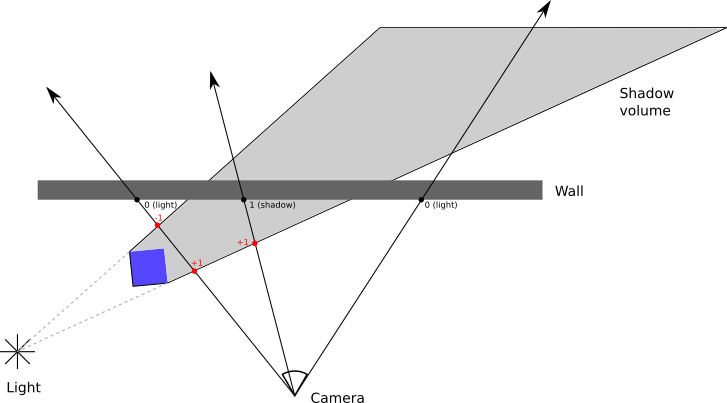

이 조건에 대해서 계산을 해볼 수도 있겠지만 어떤 한 점이 모든 섀도우 볼륨들 안에 있는 지를 확인하는 것은 <b>비싼</b> 연산이다.   
하지만 방법은 있다. 조금 말이 안되긴 하지만 말이다.   

광선은 무한하지만 shadow volume은 그렇지 않다. 이것은 언제나 레이가 shadow volume 안에서 시작해 밖에서 끝난다는 것을 의미한다.   
이 말은 빛은 언제나 shadow volume에 입장한 만큼 나간다는 것을 의미한다.   

그래서 결론적으로 표면과 광원 사이에서 counting을 하는게 아니라, 표면 이후에서 부터 카운팅을하면   
언제나 올바른 값을 얻을 수 있다는 사실을 알 수가 있다.

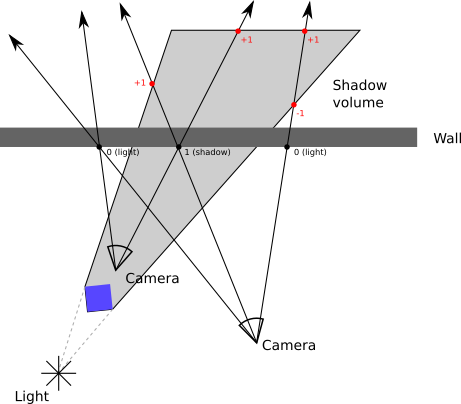

## Setting up the Stencil Buffer

우리는 rasterizer을 만드는 것이지 raytracer을 만드는 것이 아닌것을 기억해야한다.   
그래서 우리는 직접 ray와 shadow volume사이의 intersection을 카운트 하지 않고,   
카운트 해야한다.  우리는 <b>stencil buffer</b>를 이용해서 이것을 할 수가 있다.   

### Stencil Buffer

ambient light는 그림자가 없다. 그냥 더한다.

모든 빛에 대해서 다음과 같은 과정을 실행한다.

1. 스텐실 버퍼에 shadow volume의 back-face를 렌더 한다. Depth buffer테스트에서 실패할 때 마다 counter를 +1한다. 표면 이후에 빛이 shadow volume을 나가는 횟수를 세게 된다.
2. 스텐실 버퍼에 shadow volume의 front-face를 렌더 한다. Depth buffer테스트에서 실패할 때 마다 counter를 -1한다. 표면 이후에 빛이 shadow volume에 들어가는 횟수를 세게 된다.

### 전체적인 과정 

### Shadow Mapping 

이 경우는 부드럽게 그림자가 정의 된다.

레이트레이서에서 포인트에서 빛방향에 장애물이 없는지를 물었던 것처럼,   
빛이 해당 지점을 볼 수 있는 지를 판단하는 것이다.   

섀도우 맵핑에서는 Environment Rendering과 유사하게 정육면체의 6면을 채우는 느낌으로 빛에서 부터 6번 랜더링하고,   
그 결과에서 <b>depth buffer</b>만 취한다. 그리고 이 depth buffer(shadow map)은 어느 방향으로든 가장 가까운 물체까지를 거리를 알 수 있게 해준다.   

어느 포인트가 어느 다른 한 빛에 대해서 그림자에 있는 지 확인 하는 방법은 다음과 같다.
1. 빛에서의 해당 지점까지의 거리와 방향을 구한다.
2. 방향과 대응되는 shadow map 에서의 depth value 를 구한다. 
3. 만약 depth value가 1.에서 구했던 거리보다 짧다면, 해당 방향으로는 빛이 밝히고 있는 다른 지점이 있다는 뜻이므로 그림자가 있다는 것이다.
4. 아니라면 빛이 해당지점을 보고 있으니 illuminate 되는 것이 맞다.